In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
pubg_train = pd.read_csv('/Users/lumi/Documents/UCLA/Grad/18 FALL/273/Pubg/pudg/all/train_group.csv')

In [6]:
pubg_train.info()
pubg_train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592454 entries, 0 to 592453
Data columns (total 31 columns):
matchId            592454 non-null object
groupId            592454 non-null object
teamsize           592454 non-null int64
assists            592454 non-null int64
boosts             592454 non-null int64
damageDealt        592454 non-null float64
DBNOs              592454 non-null int64
headshotKills      592454 non-null int64
heals              592454 non-null int64
killPlace          592454 non-null int64
killPoints         233274 non-null float64
kills              592454 non-null int64
killStreaks        592454 non-null float64
longestKill        592454 non-null float64
maxPlace           592454 non-null int64
numGroups          592454 non-null int64
revives            592454 non-null int64
rideDistance       592454 non-null float64
roadKills          592454 non-null int64
swimDistance       592454 non-null float64
teamKills          592454 non-null int64
vehicleDestroy

(592454, 31)

In [7]:
pubg_train1 = pubg_train
pubg_train1['teamsize'] = pubg_train1['teamsize'] - 1

In [8]:
ytr = pubg_train1['winPlacePerc'].as_matrix()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [9]:
dfX = pubg_train1.drop(['winPlacePerc', 'winPoints', 'killPoints',
                       'kills', 'assists', 'boosts', 'heals','weaponsAcquired'], axis=1)

Xtrain = dfX.as_matrix()
features = dfX.drop(['groupId', 'matchId'], axis = 1).columns.tolist()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [10]:
#regularization with CV
from sklearn import linear_model
from sklearn import model_selection

In [11]:
from sklearn.model_selection import train_test_split

X_tr0, X_ts0, y_tr, y_ts = train_test_split(Xtrain, ytr, test_size = 0.2, train_size = 0.8)
#X_tr0 and X_ts0 will keep the match id and group id here

In [12]:
#remove matchid and group id from train and test data
X_tr = np.delete(X_tr0, [0, 1], 1)
X_ts = np.delete(X_ts0, [0, 1], 1)

In [13]:
#get match id and group id
id_tr = X_tr0[:,[0,1]]
id_ts = X_ts0[:, [0,1]]

In [14]:
nsamp = Xtrain.shape[0]
nf = len(features)
print('number of sample', nsamp)
print('number of feature', nf)

number of sample 592454
number of feature 21


In [15]:
from sklearn import preprocessing

X_tr = X_tr.astype(float)
X_tr = preprocessing.scale(X_tr)
X_ts = X_ts.astype(float)
X_ts = preprocessing.scale(X_ts)
#ys = preprocessing.scale(ytr)


In [3]:
#limit target variable in 0 and 1
def confine_predictions(x):
    for i in range(len(x)):
        if x[i] > 1:
            x[i] = 1
        elif x[i] < 0:
            x[i] = 0

OLS Regression

In [69]:
# Fit linear model 
reg = linear_model.LinearRegression()
reg.fit(X_tr, y_tr)

# Measure MAE for the training set and print
yhat = reg.predict(X_tr)
mae_tr = np.mean(abs(y_tr - yhat))
print('MAE on the training data =', mae_tr)



MAE on the training data = 0.07289461756088293
MAE on the test data = 0.07041978123914681


In [81]:
yhat = reg.predict(X_ts)
confine_predictions(yhat)
yhat_OLS = yhat
mae_OLS = np.mean(abs(y_ts-yhat_OLS))
print('MAE on the test data =', mae_OLS)

MAE on the test data = 0.07041978123914681


Lasso Regression

In [71]:
#Fit Lasso
lassomodel = linear_model.Lasso(alpha=1e-3)
nalpha = 100
alpha_test = np.logspace(-4, 3, nalpha)
mae_ts_lasso = np.zeros(nalpha)

In [72]:
#find optimal alpha
for it, a in enumerate(alpha_test):
        lassomodel.alpha = a
        lassomodel.fit(X_tr, y_tr)
        yhat = lassomodel.predict(X_ts)
        # MAE
        mae_ts_lasso[it] = np.mean(abs(y_ts - yhat))

In [73]:
minmae = min(mae_ts_lasso)
index = np.where(mae_ts_lasso == minmae)
print('the minimum MAE =', minmae)
print('the alpha that minimizes the MAE is', alpha_test[index])

the minimum MAE = 0.07299496813267324
the alpha that minimizes the MAE is [0.0001]


In [74]:
a = alpha_test[index]
lassomodel = linear_model.Lasso(alpha = a)
lassomodel.fit(X_tr, y_tr)
yhat = lassomodel.predict(X_ts)

In [82]:
confine_predictions(yhat)
yhat_lasso = yhat

In [84]:
mae_lasso = np.mean(abs(y_ts - yhat_lasso))
print(mae_lasso)

0.07041978123914681


In [85]:
coef = lassomodel.coef_
rowname = list(features)
table = pd.DataFrame(coef, index = rowname)
print(table)

                        0
teamsize         0.042723
damageDealt      0.022069
DBNOs           -0.016467
headshotKills   -0.001985
killPlace       -0.205174
killStreaks     -0.085615
longestKill      0.001235
maxPlace         0.015965
numGroups        0.015625
revives          0.000353
rideDistance     0.023939
roadKills        0.000053
swimDistance     0.002246
teamKills       -0.000822
vehicleDestroys  0.000000
walkDistance     0.123187
matchDuration   -0.031194
KADistance      -0.000244
KADuration      -0.018385
itemDuration     0.045507
itemDistance    -0.000623


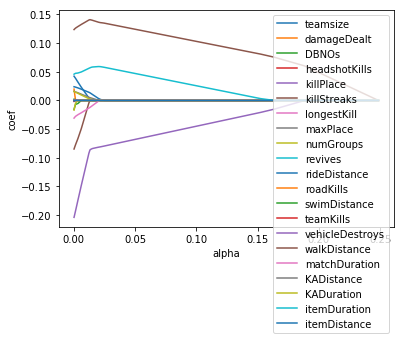

In [86]:
alphas1, coeffs, _ = linear_model.lasso_path(X_tr, y_tr, method='lasso', alpha = alpha_test)
coeffs.shape #predictor * alpha
#match an alpha with a row of coef


for coef_l in coeffs:
    plt.plot(alphas1, coef_l)
    
plt.xlabel('alpha')
plt.ylabel('coef')
plt.legend(rowname, loc='upper right')

In [87]:
nonzero = (coeffs != 0).astype(int)
nnz = np.sum(nonzero, axis=1)

nonzerotable = pd.DataFrame(nnz, index= rowname)
nonzerotable.columns = ['nnz']
nonzerotable.sort_values(by=['nnz'], ascending=False)

,nnz
walkDistance,100
killPlace,96
itemDuration,93
rideDistance,66
matchDuration,64
maxPlace,63
numGroups,62
teamsize,59
killStreaks,57
DBNOs,47


Ridge Regression

In [88]:
ridgemodel = linear_model.Ridge(alpha=1e-3)
nalpha = 100
alpha_test = np.logspace(-4, 3, nalpha)
mae_ts_ridge = np.zeros(nalpha)

In [89]:
#find optimal alpha
for it, a in enumerate(alpha_test):
        ridgemodel.alpha = a
        ridgemodel.fit(X_tr, y_tr)
        yhat = ridgemodel.predict(X_ts)
        # MAE
        mae_ts_ridge[it] = np.mean(abs(y_ts - yhat))

In [90]:
minmae = min(mae_ts_ridge)
index = np.where(mae_ts_ridge == minmae)
print('the minimum MAE =', minmae)
print('the alpha that minimizes the MAE is', alpha_test[index])

the minimum MAE = 0.07297504485773618
the alpha that minimizes the MAE is [0.0001]


In [91]:
a = alpha_test[index]
ridgemodel = linear_model.Ridge(alpha = a)
ridgemodel.fit(X_tr, y_tr)
yhat = ridgemodel.predict(X_ts)

In [92]:
confine_predictions(yhat)
yhat_ridge = yhat

In [93]:
mae_ridge = np.mean(abs(y_ts - yhat_ridge))
print(mae_ridge)

0.0704197812474344


In [94]:
coef = ridgemodel.coef_
table = pd.DataFrame(coef, index = rowname)
print(table)

                        0
teamsize         0.043026
damageDealt      0.023652
DBNOs           -0.017197
headshotKills   -0.002155
killPlace       -0.206095
killStreaks     -0.086255
longestKill      0.001427
maxPlace         0.016047
numGroups        0.015715
revives          0.000481
rideDistance     0.023977
roadKills        0.000154
swimDistance     0.002329
teamKills       -0.000886
vehicleDestroys -0.000008
walkDistance     0.122968
matchDuration   -0.031456
KADistance      -0.000323
KADuration      -0.019378
itemDuration     0.045349
itemDistance    -0.000594


In [95]:
nonzero = (coeffs != 0).astype(int)
nnz = np.sum(nonzero, axis=1)

nonzerotable = pd.DataFrame(nnz, index= rowname)
nonzerotable.columns = ['nnz']
nonzerotable.sort_values(by=['nnz'], ascending=False)

,nnz
walkDistance,100
killPlace,96
itemDuration,93
rideDistance,66
matchDuration,64
maxPlace,63
numGroups,62
teamsize,59
killStreaks,57
DBNOs,47


Random Forest

In [96]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100)

In [97]:
rf.fit(X_tr, y_tr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [102]:
yhat = rf.predict(X_ts)
confine_predictions(yhat)
yhat_rf = yhat
mae_rf = np.mean(abs(y_ts - yhat_rf))
print('MAE:', mae_rf)

MAE: 0.05192607331501881


Boosting

In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [22]:
boosting = XGBClassifier(n_estimators = 1)

In [ ]:
boosting.fit(X_tr, y_tr)

In [ ]:
yhat = boosting.predict(X_ts)
confine_predictions(yhat)
yhat_boosting = yhat
mae_boosting = np.mean(abs(y_ts - yhat_boosting))
print('MAE:', mae_boosting)

In [16]:
#output test train file
X_tr_output = pd.DataFrame(X_tr)
X_ts_output = pd.DataFrame(X_ts)
y_tr_output = pd.DataFrame(y_tr)
y_ts_output = pd.DataFrame(y_ts)


In [17]:
pd.DataFrame.to_csv(X_tr_output, '/Users/lumi/Documents/UCLA/Grad/18 FALL/273/Pubg/pudg/all/X_tr.csv')

In [18]:
pd.DataFrame.to_csv(X_ts_output, '/Users/lumi/Documents/UCLA/Grad/18 FALL/273/Pubg/pudg/all/X_ts.csv')

In [19]:
pd.DataFrame.to_csv(y_tr_output, '/Users/lumi/Documents/UCLA/Grad/18 FALL/273/Pubg/pudg/all/y_tr.csv')

In [20]:
pd.DataFrame.to_csv(y_ts_output, '/Users/lumi/Documents/UCLA/Grad/18 FALL/273/Pubg/pudg/all/y_ts.csv')